# Preprocessing 
- variable encoding and transformation
- X/y split
- train/test split
- feature selection

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'

#### Features

In [3]:
categorical_feats = {
    "SEX_A": "Sex of Sample Adult", # sex
    "HISPALLP_A": "Single and multiple race groups with Hispanic origin", # race
    "MARITAL_A": "Sample adult's current marital status", # marital status
    "EDUCP_A": "Educational level of sample adult", # education
    "URBRRL": "2013 NCHS Urban-Rural Classification Scheme for Counties", # urban/rural
    "RATCAT_A": "Ratio of family income to poverty threshold for SA's family", # poverty
    "DIBEV_A": "Ever had diabetes",
    "DEPEV_A": "Ever had depression",
    "ANXEV_A": "Ever had anxiety disorder",
    "COPDEV_A": "Ever been told you had COPD, emphysema, or chronic bronchitis?",
    "ARTHEV_A": "Ever had arthritis",
    "DEMENEV_A": "Ever had dementia",
    "HEPEV_A": "Ever had hepatitis",
    "CROHNSEV_A": "Ever had Crohn's disease",
    "ULCCOLEV_A": "Ever had ulcerative colitis",
    "CFSEV_A": "Ever had Chronic Fatigue Syndrome",
    "HLTHCOND_A": "Weakened immune system due to health condition",
    "MEDRXTRT_A": "Weakened immune system due to prescriptions",
    "SHTCVD191_A": "COVID-19 vaccination",
    "SMKCIGST_A": "Cigarette smoking status"
}

mixed_feats = {
    "AGEP_A": "Age of Sample Adult (top-coded)" # age
}

In [4]:
## FEATURE INFORMATION

demographic_info = {
    "AGEP_A": "Age of Sample Adult (top-coded)",
    "SEX_A": "Sex of Sample Adult",
    "HISP_A": "Hispanic ethnicity of Sample Adult",
    "HISPALLP_A": "Single and multiple race groups with Hispanic origin",
    "RACEALLP_A": "Single and multiple race groups",
    "MARITAL_A": "Sample adult's current marital status",
    "SPOUSLIV_A": "Sample adult's spouse lives here",
    "EDUCP_A": "Educational level of sample adult",
    "PCNT18UPTC": "Top-coded count of persons 18 or older in the household",
    "OVER65FLG_A": "Indicator for at least 1 person aged 65+ in Sample Adult family",
    "MLTFAMFLG_A": "Indicator for multifamily households",
    "PCNTKIDS_A": "Number of children in Sample Adult family, top-coded 3+",
    "PARSTAT_A": "Parental Status of sample adult",
    "CEVOLUN1_A": "Volunteer for organization or association",
    "CEVOLUN2_A": "Other volunteer activities",
    "FWIC12M_A": "Receive WIC benefits, past 12 months",
    "INCWRKO_A": "Income from wages"
}

chronic_info = {
    "EVERCOVD_A": "Ever had COVID-19",
    "LONGCOVD1_A": "Had COVID-19 symptoms for 3 or more months",
    # "SYMPNOW1_A": "Currently has COVID-19 symptoms",
    # "LCVDACT_A": "COVID-19 impacts activities",
    "DEPEV_A": "Ever had depression",
    "ANXEV_A": "Ever had anxiety disorder",
    "COPDEV_A": "Ever been told you had COPD, emphysema, or chronic bronchitis?",
    "ARTHEV_A": "Ever had arthritis",
    "DEMENEV_A": "Ever had dementia",
    "DIBTYPE_A": "Diabetes type",
    "HEPEV_A": "Ever had hepatitis",
    "CROHNSEV_A": "Ever had Crohn's disease",
    "ULCCOLEV_A": "Ever had ulcerative colitis",
    "CFSEV_A": "Ever had Chronic Fatigue Syndrome",
    "HLTHCOND_A": "Weakened immune system due to health condition",
    "MEDRXTRT_A": "Weakened immune system due to prescriptions",
    "PAIAMNT_A": "How much pain last time",
    "PAIWKLM3M_A": "How often pain limits life or work",
    "DENPREV_A": "Time since last dental exam or cleaning",
    "DENDL12M_A": "Delayed dental care due to cost, past 12 months",
    "SHTCVD191_A": "COVID-19 vaccination",
    "SHTCVD19NM1_A": "Number of COVID-19 vaccinations",
    "SHOTTYPE2_A": "Brand of first COVID-19 shot",
    "CVDVAC1M1_A": "Month of most recent COVID-19 vaccination",
    "CVDVAC1Y1_A": "Year of most recent COVID-19 vaccination",
    "SHTPNUEV_A": "Ever had pneumonia shot",
    "SHTPNEUNB_A": "Number of pneumonia shots",
    "SHTSHINGL1_A": "Ever had a shingles vaccination"
}

# list of all columns to select
feat_names = list(chronic_info.keys()) + list(demographic_info.keys())

## Preprocess using all features

In [20]:
## USE ALL FEATURES

def preprocess_all_columns(df_full):
    """
    Preprocess all features.  Several assumptions are made:
    - null values of the target (long covid) are dropped
    - features with greater than 8000 missing values are dropped
    - values are imputed before the train test split
    - continuous values are arbitrarily defined
    """
    encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
    scaler = StandardScaler().set_output(transform="pandas")
    scaler = MinMaxScaler().set_output(transform="pandas")
    imputer = SimpleImputer(strategy='most_frequent').set_output(transform="pandas")
    
    # filter age
    new_df = df_full[df_full["AGEP_A"] <= 84].reset_index(drop=True)
    # filter ys
    # subset for features and drop null values
    df = new_df.dropna(subset=y_name)
    df = df[df[y_name] != 9]
    # drop null columns
    null_cols = df.columns[df.isna().all()].values
    low_counts = df.columns[df.isna().apply(sum) > 8000].values
    df_droppedcols = df.drop(columns=np.hstack((null_cols, low_counts, ['HHX'], y_name)))
    
    # impute values 
    imputed = imputer.fit_transform(df_droppedcols)

    # define continuous and categorical features
    continuous = df_droppedcols.columns[df_droppedcols.apply(np.unique).apply(len) > 15] 
    categorical = df_droppedcols.columns[~df_droppedcols.columns.isin(continuous)]

    # scale and encode
    cont_df =  scaler.fit_transform(imputed.loc[:, continuous])
    cat_df = encoder.fit_transform(imputed.loc[:,categorical])
    
    processed_df = pd.concat((cont_df, cat_df), axis=1)
    ## END PREPROCESSING
    
    X = processed_df.copy()
    y = df.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

    return X_train, X_test, y_train, y_test

## Preprocess a subset of features

In [29]:
## PIPELINE: preprocess subset features

def preprocess_feature_subset(df_full, categorical_feats):
    """
    Subsets dataframe for categorical_feats + AGE.
    """
    def filter_age(df):
        return df[df["AGEP_A"] <= 84].reset_index(drop=True)
    
    categorical_features = df_full.loc[:, categorical_feats.keys()].columns
    
    # Define preprocessing for the 'age' column
    age_pipeline = Pipeline([
        ('scaler', MinMaxScaler()) ## EDITED
    ])
    
    # categorical columns
    categorical_pipeline = Pipeline([
        ('encoder', OneHotEncoder(drop='first')) 
    ])
    
    # age + categorical pipelines
    full_pipeline = Pipeline([
        # ('filter_age', FunctionTransformer(filter_age)),  # Filter rows with age > 84 or na
        ('preprocessing', ColumnTransformer([
            ('age', age_pipeline, ["AGEP_A"]),
            ('categorical', categorical_pipeline, categorical_features)
        ]))
    ])

    # filter dataframe for relevant targets
    target_df = filter_age(df_full).dropna(subset=y_name)
    target_df = target_df[target_df[y_name] != 9]

    # apply pipeline
    processed_data = full_pipeline.fit_transform(target_df)

    if hasattr(processed_data, "toarray"):  # Check if it's a sparse matrix
        processed_data = processed_data.toarray()
    
    # get feature names from the transformers
    age_feature = ["AGEP_A_scaled"]  # or whatever you want to name the scaled age column
    categorical_feature_names = full_pipeline.named_steps['preprocessing']\
        .transformers_[1][1]\
        .named_steps['encoder']\
        .get_feature_names_out(categorical_features)
    
    feature_names = age_feature + list(categorical_feature_names)
    
    X_processed = pd.DataFrame(processed_data, columns=feature_names)

    # get y
    y = target_df.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=207)

    return X_train, X_test, y_train, y_test

### Alternative feature selection

SCORES ABOVE 8:
Feature SEX_A_2: 23.77914708219255
Feature HISPALLP_A_4: 23.667741532547332
Feature MARITAL_A_3: 9.585602694829394
Feature EDUCP_A_3: 19.724152516707765
Feature EDUCP_A_5: 15.79082532586023
Feature EDUCP_A_6: 15.779187300997163
Feature EDUCP_A_9: 19.79202391407292
Feature EDUCP_A_10: 14.873478775722846
Feature URBRRL_4: 14.816145792464923
Feature RATCAT_A_2: 10.31233309212485
Feature RATCAT_A_4: 21.540129549914703
Feature RATCAT_A_6: 8.776328096686926
Feature RATCAT_A_9: 10.119909826304443
Feature RATCAT_A_14: 45.95125229198898
Feature DEPEV_A_2: 35.46162039977737
Feature ANXEV_A_2: 32.47785871738005
Feature ANXEV_A_9: 9.002184210837859
Feature ARTHEV_A_2: 26.140140174401765
Feature MEDRXTRT_A_9: 8.50673601067151
Feature SHTCVD191_A_2: 8.125883520828284
Feature SMKCIGST_A_4: 10.116182706831713


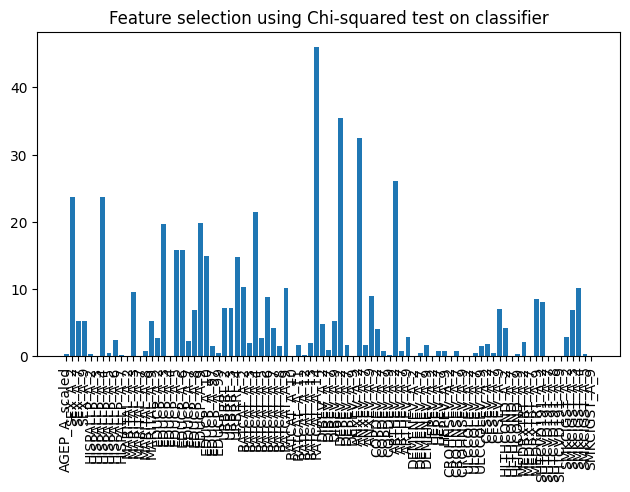

In [34]:
# feature selection
def select_features(X_train, y_train, X_test):
    # perform a simple mean imputation to handle missingness
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.fit_transform(X_test)

    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train_imputed, y_train)
    X_train_fs = fs.transform(X_train_imputed)
    X_test_fs = fs.transform(X_test_imputed)
    return X_train_fs, X_test_fs, fs


def print_top_k_scores(X_train, fs, k=10):
    # what are scores for the features
    print(f"SCORES ABOVE {k}:")
    feats = []
    for i, feat in enumerate(X_train.columns):
        if fs.scores_[i] > k:
            print(f'Feature {feat}: {fs.scores_[i]}')
            feats.append(feat)
    return feats


def plot_feature_scores(X_train, fs):
    # plot the scores
    fig, ax = plt.subplots()
    ax.bar(list(X_train.columns), fs.scores_, label=list(X_train.columns))
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title("Feature selection using Chi-squared test on classifier")
    plt.show()

# feature selection
X_train, X_test, y_train, y_test = preprocess_feature_subset(df_full, categorical_feats)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
feats = print_top_k_scores(X_train, fs, k=8)
plot_feature_scores(X_train, fs)

In [37]:
feats

['SEX_A_2',
 'HISPALLP_A_4',
 'MARITAL_A_3',
 'EDUCP_A_3',
 'EDUCP_A_5',
 'EDUCP_A_6',
 'EDUCP_A_9',
 'EDUCP_A_10',
 'URBRRL_4',
 'RATCAT_A_2',
 'RATCAT_A_4',
 'RATCAT_A_6',
 'RATCAT_A_9',
 'RATCAT_A_14',
 'DEPEV_A_2',
 'ANXEV_A_2',
 'ANXEV_A_9',
 'ARTHEV_A_2',
 'MEDRXTRT_A_9',
 'SHTCVD191_A_2',
 'SMKCIGST_A_4']

In [55]:

important = list(set([re.search('(.+)_\d+',feat).group(1) for feat in feats]))
print(important)

['SEX_A', 'URBRRL', 'MARITAL_A', 'ANXEV_A', 'SHTCVD191_A', 'HISPALLP_A', 'DEPEV_A', 'SMKCIGST_A', 'RATCAT_A', 'MEDRXTRT_A', 'EDUCP_A', 'ARTHEV_A']


In [54]:
df_full.loc[:, important]

,SEX_A,URBRRL,MARITAL_A,ANXEV_A,SHTCVD191_A,HISPALLP_A,DEPEV_A,SMKCIGST_A,RATCAT_A,MEDRXTRT_A,EDUCP_A,ARTHEV_A
0,1,3,2,2,1,3,1,4,4,2,1,1
1,1,4,3,2,1,2,2,1,8,2,8,2
2,1,4,1,2,1,3,2,4,14,2,5,2
3,2,4,1,2,1,2,2,3,10,2,9,2
4,2,4,3,2,1,2,2,4,5,2,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...
29517,2,4,3,2,1,2,1,3,6,2,5,1
29518,2,4,1,2,1,2,1,4,14,2,7,2
29519,1,4,1,2,2,2,2,4,14,2,8,2
29520,2,4,1,2,2,2,2,1,12,2,7,1


In [31]:
def l1_reg_on_all_features():
    """IDENTIFY UNIMPORTANT FEATURES USING ALL VARIABLES"""
    # split X and y, the additional dropped columns do not have any data
    X = df_full.drop(columns=['HHX','LONGCOVD1_A','OGFLG_A', 'OPFLG_A', 
                              'CHFLG_A', 'PRPLCOV2_C_A', 'GALLBAGETC_A', 
                              'CHHDHP_A','CHDEDUC_A', 'CHPREM_A', 'CHXCHNG_A'])
    y = df_full.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=207)
    
    # perform a simple mean imputation to handle missingness
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.fit_transform(X_test)
    
    # create logistic regression with regularization to set coefficients to 0
    lr = LogisticRegression(penalty='l1', solver='liblinear')
    lr.fit(X_train_imputed, y_train)
    print("SCORE:",lr.score(X_test_imputed, y_test))
    
    # record features that were set to 0
    not_zero = ((lr.coef_ >= 0.1)[0] | (lr.coef_ <= -0.1)[0])
    unimportant = X.columns[~not_zero]
    important = X.columns[not_zero]
    
    ## print full list
    # print(", ".join([important[j] for j in range(len(important))]))

    return important, unimportant

In [ ]:
important, unimportant = l1_reg_on_all_features()

In [ ]:
feats = list(important.values)
feats.append(y_name)
test_df = df_full.loc[:,important].loc[:,~df_full.loc[:,important].isna().any()]
test_df[y_name] = df_full[y_name]
test_df = test_df.dropna(subset=y_name)
test_df = test_df[test_df[y_name] != 9]

X = test_df.drop(columns=y_name)
y = test_df.loc[:, y_name]
y = (y == 1) * 1 # encode as 0 / 1 values

encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
X_encoded = encoder.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=207)

lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

In [ ]:
pd.DataFrame(important).to_csv("l1reg_important_feats.csv",index=False)

In [ ]:
X_train, X_test, y_train, y_test = preprocess_feature_subset(df_full, categorical_feats)

# perform a simple mean imputation to handle missingness
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_test)

# create logistic regression with regularization to set coefficients to 0
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train_imputed, y_train)
lr.score(X_test_imputed, y_test)

In [ ]:
# record features that were set to 0
unimportant_idx = ((-0.0001 < lr.coef_) & (lr.coef_ < 0.0001))[0]
unimportant = X_train.columns[unimportant_idx]
important = X_train.columns[~unimportant_idx]
important

In [ ]:
for name, score in sorted(zip(X_train.columns, lr.coef_[0]), key=lambda x:np.abs(x[1]), reverse=True):
    if name == 'AGEP_A_scaled':
        descr = mixed_feats["AGEP_A"]
    else:
        descr = categorical_feats[re.sub(r'_[^_]+$', '', name)]
    print(f"{descr} ({name}): {score:.2f}")

In [ ]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'
feat_names = ["AGEP_A", "SEX_A", "SHTCVD191_A", "LONGCOVD1_A"]

# subset for features and drop null values
df = df_full.loc[:, feat_names].dropna(subset=y_name)
df = df[df[y_name] != 9]
print("Shape after feature selection and dropping lcovid nulls:",df.shape)

# FIX ATTRIBUTES
df["SEX_A"] = (df["SEX_A"] == 1) * 1  # 1 is male 
df["SHTCVD191_A"] = (df["SHTCVD191_A"] == 1) * 1  # 1 is yes covid shot

# split X and y
X = df.loc[:, df.columns != y_name]
y = df.loc[:, y_name]
y = (y == 1) * 1 # encode as 0 / 1 values

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

# create logistic regression with regularization to set coefficients to 0
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

## AFTER BAYESIAN FEATURE SELECTION

In [ ]:
feats = ['PRDEDUC1_A',
 'CITZNSTP_A',
 'VISIONDF_A',
 'BPLAST_A',
 'PCNTADWKP1_A',
 'PAIAFFM3M_A',
 'PHQ43_A',
 'COLORECTEV_A',
 'HEARINGDF_A',
 'SOCWRKLIM_A',
 'ARTHEV_A',
 'VIMREAD_A',
 'ANXFREQ_A',
 'MRIHAD_A',
 'HOUYRSLIV_A',
 'COLOGUARD1_A',
 'CFSEV_A',
 'UPPRAISE_A',
 'CBALHDINJ_A',
 'VIGIL3_A',
 'DISCRIM5_A',
 'DISCRIM1_A',
 'INCWRKO_A',
 'PRDNCOV1_A',
 'NUMCAN_A',
 'FSNAP12M_A',
 'SAPARENTSC_A',
 'CROHNSEV_A',
 'CHLEV_A',
 'VIMDREV_A',
 'PAITOOTH3M_A',
 'COMDIFF_A',
 'PAYBLL12M_A',
 'PRRXCOV1_A',
 'DIFF_A',
 'STREV_A',
 'DISCRIM4_A',
 'PARSTAT_A',
 'EXCHPR1_A',
 'PLNWRKR1_A',
 'FDSBALANCE_A',
 'SHTCVD19NM1_A',
 'CTCOLEV1_A',
 'COGMEMDFF_A',
 'EMPHEALINS_A',
 'PAIHDFC3M_A',
 'MEDICAID_A',
 'ANXEV_A',
 'PCNTADWFP1_A',
 'URGNT12MTC_A',
 'SHTFLUM_A',
 'EMERG12MTC_A',
 'DEPFREQ_A',
 'FDSRUNOUT_A',
 'VIMMDEV_A',
 'AVAIL_A',
 'FDSLAST_A',
 'VIGIL2_A',
 'HOUSECOST_A',
 'DEPMED_A',
 'DEPLEVEL_A',
 'DEPEV_A',
 'ACCSSINT_A',
 'EDUCP_A',
 'INCSSISSDI_A',
 'DISCRIM3_A',
 'MEDICARE_A',
 'VIRAPP12M_A',
 'MEDRXTRT_A',
 'MAMEV_A',
 'VIGIL4_A',
 'MAXEDUCP_A']

In [ ]:
# PRINT NUMBER OF RESPONDANTS WITH OR WITHOUT LCOVID

# df_full[y_name].value_counts()
# 12893/2398

# for feat in feats:
#     temp = df[[feat, y_name]]
#     print(f"\nFEATURE: {feat}")
#     print(f"NA VALUES: {temp[feat].isna().sum()}")
#     print(f"LCovid rate: {temp.groupby(by=y_name).sum()[feat].loc[2.0] / temp.groupby(by=y_name).sum()[feat].loc[1.0]}")
#     display(temp.groupby(by=y_name).sum())

In [ ]:
# features are all categorical
df = df_full.dropna(subset=y_name)
df = df[df[y_name] != 9]
bayes_df = df[feats].loc[:,~df[feats].isna().any()]
bayes_df.apply(lambda x:x.unique())
bayes_df

In [ ]:
## PREPROCESS AFTER BAYES FEATURE SELECTION

def preprocess_after_bayes(df_full):
    """
    Preprocess all features.  Assumptions made:
    - null values of the target (long covid) are dropped
    - features selected from bayes with any null values are dropped
    """
    encoder = OneHotEncoder(drop='first', sparse_output=False).set_output(transform="pandas")
    
    df = df_full.dropna(subset=y_name)
    df = df[df[y_name] != 9]
    bayes_df = df[feats].loc[:,~df[feats].isna().any()]
    bayes_df.apply(lambda x:x.unique())
    bayes_df
    
    cat_df = encoder.fit_transform(bayes_df)
    
    X = cat_df.copy()
    y = df.loc[:, y_name]
    y = (y == 1) * 1 # encode as 0 / 1 values
    
    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=207)

    return X_train, X_test, y_train, y_test